In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


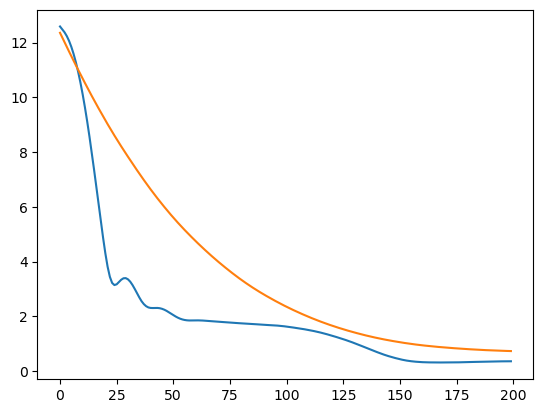

In [149]:
from __future__ import annotations
import sys
sys.path.append('..')  #let me import stuff from the path above 
from typing import (Callable, Dict, Generic, Iterator, Iterable, List,
                    Mapping, Optional, Sequence, Tuple, TypeVar, overload)
from itertools import *
from function_approx import *
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

Triple = Tuple[float, float, float]
Aug_Triple = Tuple[float, float, float, float]
DataSeq = Sequence[Tuple[Triple, float]]

def example_model_data_generator() -> Iterator[Tuple[Triple, float]]:
    coeffs: Aug_Triple = (2., 10., 4., -6.)
    d = norm(loc=0, scale=0.3)
    while True:
        pt: np.ndarray = np.random.randn(3)
        x_val: Triple = (pt[0], pt[1], pt[2])
        y_val: float = coeffs[0] + np.dot(coeffs[1:], pt) + \
            d.rvs(size=1)[0]
        yield (x_val, y_val)

def data_seq_generator(
    data_generator: Iterator[Tuple[Triple, float]],
    num_pts: int
) -> Iterator[DataSeq]:
    while True:
        pts: DataSeq = list(islice(data_generator, num_pts))
        yield pts
    
def feature_functions():
    return [lambda _ : 1., lambda x: x[0], lambda x: x[1], lambda x: x[2]]

def adam_gradient():
    return AdamGradient(
        learning_rate=0.1,
        decay1=0.9,
        decay2=0.999
    )

def get_linear_model() -> LinearFunctionApprox[Triple]:
    ffs = feature_functions()
    ag = adam_gradient()
    return LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=ag,
        regularization_coeff=0.05,
        direct_solve=True
    )

###Now Deep Neural Netowrk

def get_dnn_model() -> DNNApprox[Triple]:
    ffs = feature_functions()
    ag = adam_gradient()
    
    def relu(arg: np.ndarray) -> np.ndarray:
        return np.vectorize(lambda x: x if x > 0. else 0.)(arg)
    
    def relu_deriv(res: np.ndarray) -> np.ndarray:
        return np.vectorize(lambda x: 1. if x > 0. else 0 )(res)
    
    def identity(arg: np.ndarray) -> np.ndarray:
        return arg
    
    def identity_deriv(res: np.ndarray) -> np.ndarray:
        return np.ones_like(res)
    
    ds = DNNSpec(
        neurons=[2],
        bias=True,
        hidden_activation=relu,
        hidden_activation_deriv=relu_deriv,
        output_activation=identity,
        output_activation_deriv=identity_deriv
    )
    
    return DNNApprox.create(
        feature_functions=ffs,
        dnn_spec=ds,
        adam_gradient=ag,
        regularization_coeff=0.05
    )

training_num_pts: int = 1000
test_num_pts: int = 10000
training_iterations: int = 200
data_gen: Iterator[Tuple[Triple, float]] = example_model_data_generator()
training_data_gen: Iterator[DataSeq] = data_seq_generator(
    data_gen,
    training_num_pts
)

test_data: DataSeq = list(islice(data_gen, test_num_pts))
direct_solve_lfa = get_linear_model().solve(next(training_data_gen))
direct_solve_rmse: float = direct_solve_lfa.rmse(test_data)
direct_solve_rmse #This is right :) cause the input standard deviation was 0.3

linear_model_rmse_seq: Sequence[float] = []

for lfa in islice(
    get_linear_model().iterate_updates(training_data_gen),
    training_iterations
):
    this_rmse: float = lfa.rmse(test_data)
    linear_model_rmse_seq.append(this_rmse)
    iter: int = len(linear_model_rmse_seq)
#     # print(f"Iteration {iter:d}: RMSE = {this_rmse:.3f}")

dnn_model_rmse_seq: List[float] = []
for dfa in islice(
    get_dnn_model().iterate_updates(training_data_gen),
    training_iterations
):
    this_rmse: float = dfa.rmse(test_data)
    dnn_model_rmse_seq.append(this_rmse)
    iter: int = len(dnn_model_rmse_seq)
    # print(f"Iteration {iter:d}: RMSE = {this_rmse:.3f}")


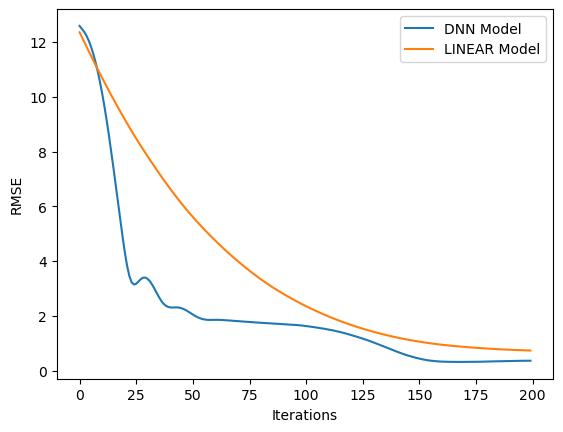

In [153]:
x = [x for x in range(training_iterations)]
plt.plot(x, dnn_model_rmse_seq, label='DNN Model')
plt.plot(x, linear_model_rmse_seq, label='LINEAR Model')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.show()